In [56]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score

In [63]:
# Save the train and test DataFrames
X_TRAIN_DIR = "processed_data/glcm/X_train_SMOTE.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train_SMOTE.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [70]:
def logistic_regression(X_train, y_train, X_test, y_test, c, reg, max_iter, multi_class, class_weight):
    """
    Perform logistic regression, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """

    # Fit the logistic regression model
    model = LogisticRegression(solver="lbfgs", C=c, penalty=reg, multi_class=multi_class, max_iter=max_iter, class_weight=class_weight)
    model.fit(X_train, y_train) 

    # Predict labels
    y_pred = model.predict(X_test)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    print("F2 Score:", f2_score)

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient:", mcc)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

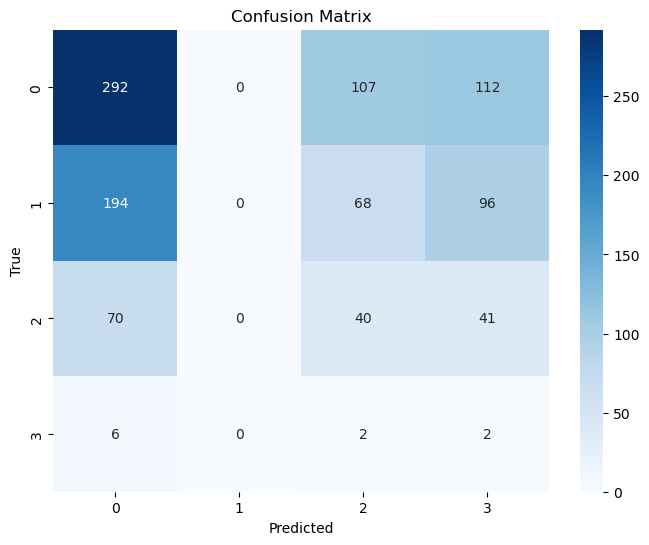

F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       511
           1       0.00      0.00      0.00       358
           2       0.18      0.26      0.22       151
           3       0.01      0.20      0.02        10

    accuracy                           0.32      1030
   macro avg       0.18      0.26      0.19      1030
weighted avg       0.28      0.32      0.30      1030



In [71]:
logistic_regression(X_train, y_train, X_test, y_test, 1, "l2",100000, "multinomial", None)

In [66]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def objective(trial):
    # Define the search space for hyperparameters
    c = trial.suggest_loguniform('C', 1e-5, 1e5)
    reg = trial.suggest_categorical('penalty', ['l2','none'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # Train and evaluate the logistic regression model
    f2_score, mcc = logistic_regression_tune(X_train, y_train, X_test, y_test, c, reg, max_iter, multi_class, class_weight)

    # Optimize for F2 score, you can change this to MCC or other metrics
    return f2_score

def logistic_regression_tune(X_train, y_train, X_test, y_test, c, reg, max_iter, multi_class, class_weight):
    # Fit the logistic regression model
    model = LogisticRegression(solver="lbfgs", C=c, penalty=reg, multi_class=multi_class, max_iter=max_iter, class_weight=class_weight)
    model.fit(X_train, y_train)

    # Predict labels
    y_pred = model.predict(X_test)

    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    print("F2 Score:", f2_score)

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient:", mcc)
    print("")

    return f2_score, mcc

# Assuming X_train, y_train, X_test, y_test are your training and testing data
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2023-11-13 01:00:38,534] A new study created in memory with name: no-name-adfbe509-6d7c-459f-84f8-3ce046a9086c


[I 2023-11-13 01:00:39,060] Trial 0 finished with value: 0.3139937348351449 and parameters: {'C': 0.047734408002264576, 'penalty': 'l2', 'max_iter': 500, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 0 with value: 0.3139937348351449.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:39,474] Trial 1 finished with value: 0.3139937348351449 and parameters: {'C': 1849.4918988758393, 'penalty': 'l2', 'max_iter': 148, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3139937348351449.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:39,978] Trial 2 finished with value: 0.3139937348351449 and parameters: {'C': 0.025551941649657687, 'penalty': 'l2', 'max_iter': 744, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3139937348351449.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:40,409] Trial 3 finished with value: 0.3139937348351449 and parameters: {'C': 0.15694339142256417, 'penalty': 'none', 'max_iter': 135, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3139937348351449.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:40,821] Trial 4 finished with value: 0.3139937348351449 and parameters: {'C': 1249.3545375421206, 'penalty': 'l2', 'max_iter': 417, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 0 with value: 0.3139937348351449.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:41,242] Trial 5 finished with value: 0.3139937348351449 and parameters: {'C': 0.0652970814174974, 'penalty': 'none', 'max_iter': 678, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 0 with value: 0.3139937348351449.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:41,769] Trial 6 finished with value: 0.3589698476305756 and parameters: {'C': 263.75225305422504, 'penalty': 'none', 'max_iter': 313, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 6 with value: 0.3589698476305756.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:00:42,382] Trial 7 finished with value: 0.3754284672657875 and parameters: {'C': 0.001913249625401446, 'penalty': 'l2', 'max_iter': 821, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:42,768] Trial 8 finished with value: 0.3139937348351449 and parameters: {'C': 0.13784873210213955, 'penalty': 'l2', 'max_iter': 240, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:43,280] Trial 9 finished with value: 0.3589698476305756 and parameters: {'C': 358.51137963658744, 'penalty': 'l2', 'max_iter': 345, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:00:43,960] Trial 10 finished with value: 0.3754284672657875 and parameters: {'C': 6.246348447726816e-05, 'penalty': 'none', 'max_iter': 966, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:44,615] Trial 11 finished with value: 0.3754284672657875 and parameters: {'C': 3.2798395692847364e-05, 'penalty': 'none', 'max_iter': 999, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:45,284] Trial 12 finished with value: 0.3754284672657875 and parameters: {'C': 6.500504053269602e-05, 'penalty': 'none', 'max_iter': 999, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:45,935] Trial 13 finished with value: 0.3754284672657875 and parameters: {'C': 0.0008398296950389201, 'penalty': 'none', 'max_iter': 823, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:46,581] Trial 14 finished with value: 0.3754284672657875 and parameters: {'C': 0.0010101213161988962, 'penalty': 'l2', 'max_iter': 879, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:47,243] Trial 15 finished with value: 0.3754284672657875 and parameters: {'C': 1.6179210068807725e-05, 'penalty': 'none', 'max_iter': 642, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:47,883] Trial 16 finished with value: 0.3754284672657875 and parameters: {'C': 0.0011471271719849937, 'penalty': 'l2', 'max_iter': 871, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:48,529] Trial 17 finished with value: 0.3754284672657875 and parameters: {'C': 6.55870616272786, 'penalty': 'none', 'max_iter': 602, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:49,187] Trial 18 finished with value: 0.3754284672657875 and parameters: {'C': 0.00015078687121675578, 'penalty': 'none', 'max_iter': 792, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:49,851] Trial 19 finished with value: 0.3754284672657875 and parameters: {'C': 72071.67075086913, 'penalty': 'l2', 'max_iter': 894, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:50,497] Trial 20 finished with value: 0.3754284672657875 and parameters: {'C': 0.00879318192678527, 'penalty': 'l2', 'max_iter': 727, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:51,152] Trial 21 finished with value: 0.3754284672657875 and parameters: {'C': 1.3673635252798755e-05, 'penalty': 'none', 'max_iter': 998, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:51,792] Trial 22 finished with value: 0.3754284672657875 and parameters: {'C': 0.00010602342684061503, 'penalty': 'none', 'max_iter': 943, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:52,450] Trial 23 finished with value: 0.3754284672657875 and parameters: {'C': 1.1867199825915075e-05, 'penalty': 'none', 'max_iter': 927, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:53,116] Trial 24 finished with value: 0.3754284672657875 and parameters: {'C': 0.0037532054912116056, 'penalty': 'none', 'max_iter': 804, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:53,769] Trial 25 finished with value: 0.3754284672657875 and parameters: {'C': 0.000535247463142728, 'penalty': 'none', 'max_iter': 998, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:54,419] Trial 26 finished with value: 0.3754284672657875 and parameters: {'C': 0.00023486357210941874, 'penalty': 'none', 'max_iter': 516, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:55,074] Trial 27 finished with value: 0.3754284672657875 and parameters: {'C': 0.005093751500017069, 'penalty': 'none', 'max_iter': 833, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:55,738] Trial 28 finished with value: 0.3754284672657875 and parameters: {'C': 5.5935812518946384e-05, 'penalty': 'l2', 'max_iter': 935, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:56,295] Trial 29 finished with value: 0.3589698476305756 and parameters: {'C': 4.4633730601738895e-05, 'penalty': 'l2', 'max_iter': 603, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:00:56,958] Trial 30 finished with value: 0.3754284672657875 and parameters: {'C': 0.00029417779271811984, 'penalty': 'none', 'max_iter': 751, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:57,613] Trial 31 finished with value: 0.3754284672657875 and parameters: {'C': 4.544364124459843e-05, 'penalty': 'none', 'max_iter': 997, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:58,282] Trial 32 finished with value: 0.3754284672657875 and parameters: {'C': 8.290304609344898e-05, 'penalty': 'none', 'max_iter': 952, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:58,957] Trial 33 finished with value: 0.3754284672657875 and parameters: {'C': 1.0904581287711629e-05, 'penalty': 'none', 'max_iter': 867, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:00:59,470] Trial 34 finished with value: 0.3139937348351449 and parameters: {'C': 0.00020769724742738472, 'penalty': 'none', 'max_iter': 926, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:00:59,922] Trial 35 finished with value: 0.3139937348351449 and parameters: {'C': 0.0012088953167075952, 'penalty': 'l2', 'max_iter': 969, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:00,672] Trial 36 finished with value: 0.3754284672657875 and parameters: {'C': 0.015192145032239137, 'penalty': 'none', 'max_iter': 763, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:01,112] Trial 37 finished with value: 0.3139937348351449 and parameters: {'C': 0.002864431000526594, 'penalty': 'none', 'max_iter': 693, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:01,786] Trial 38 finished with value: 0.3754284672657875 and parameters: {'C': 0.0424152803047048, 'penalty': 'l2', 'max_iter': 898, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:02,233] Trial 39 finished with value: 0.3139937348351449 and parameters: {'C': 3.766166383102578e-05, 'penalty': 'none', 'max_iter': 848, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:02,866] Trial 40 finished with value: 0.3743513584161569 and parameters: {'C': 0.00022076562758462762, 'penalty': 'l2', 'max_iter': 406, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3743513584161569
Matthews Correlation Coefficient: 0.13250645834003585



[I 2023-11-13 01:01:03,511] Trial 41 finished with value: 0.3754284672657875 and parameters: {'C': 0.0006949182039110535, 'penalty': 'none', 'max_iter': 819, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:04,169] Trial 42 finished with value: 0.3754284672657875 and parameters: {'C': 0.001748724020501756, 'penalty': 'none', 'max_iter': 895, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:04,823] Trial 43 finished with value: 0.3754284672657875 and parameters: {'C': 0.00039182584087527376, 'penalty': 'none', 'max_iter': 972, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:05,493] Trial 44 finished with value: 0.3754284672657875 and parameters: {'C': 0.013486217967138048, 'penalty': 'none', 'max_iter': 776, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:06,042] Trial 45 finished with value: 0.3589698476305756 and parameters: {'C': 0.0005900370556007062, 'penalty': 'none', 'max_iter': 718, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:01:06,690] Trial 46 finished with value: 0.3754284672657875 and parameters: {'C': 3.265380166312058e-05, 'penalty': 'l2', 'max_iter': 840, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:07,349] Trial 47 finished with value: 0.3754284672657875 and parameters: {'C': 0.00012466386524926726, 'penalty': 'none', 'max_iter': 189, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:07,789] Trial 48 finished with value: 0.3139937348351449 and parameters: {'C': 0.004512653919796492, 'penalty': 'none', 'max_iter': 665, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:08,454] Trial 49 finished with value: 0.3754284672657875 and parameters: {'C': 0.0014977134627673422, 'penalty': 'l2', 'max_iter': 893, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:09,006] Trial 50 finished with value: 0.3589698476305756 and parameters: {'C': 9.506164087143317e-05, 'penalty': 'none', 'max_iter': 925, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:01:09,684] Trial 51 finished with value: 0.3754284672657875 and parameters: {'C': 2.5170852271029088e-05, 'penalty': 'l2', 'max_iter': 867, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:10,377] Trial 52 finished with value: 0.3743513584161569 and parameters: {'C': 0.0011572732082891636, 'penalty': 'l2', 'max_iter': 973, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3743513584161569
Matthews Correlation Coefficient: 0.13250645834003585



[I 2023-11-13 01:01:11,069] Trial 53 finished with value: 0.3754284672657875 and parameters: {'C': 0.1744860266509878, 'penalty': 'l2', 'max_iter': 798, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:11,770] Trial 54 finished with value: 0.3754284672657875 and parameters: {'C': 0.0005236830619094847, 'penalty': 'l2', 'max_iter': 910, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:12,484] Trial 55 finished with value: 0.3754284672657875 and parameters: {'C': 1.9817934401383247e-05, 'penalty': 'l2', 'max_iter': 997, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:13,279] Trial 56 finished with value: 0.3754284672657875 and parameters: {'C': 9.07267044958836e-05, 'penalty': 'none', 'max_iter': 956, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:14,074] Trial 57 finished with value: 0.3754284672657875 and parameters: {'C': 0.00022756387538340483, 'penalty': 'l2', 'max_iter': 862, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:14,866] Trial 58 finished with value: 0.3754284672657875 and parameters: {'C': 0.006350781615849772, 'penalty': 'none', 'max_iter': 574, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:15,677] Trial 59 finished with value: 0.3754284672657875 and parameters: {'C': 1.0240987758593153e-05, 'penalty': 'l2', 'max_iter': 811, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:16,424] Trial 60 finished with value: 0.3754284672657875 and parameters: {'C': 6.210657509971109e-05, 'penalty': 'none', 'max_iter': 949, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:17,201] Trial 61 finished with value: 0.3754284672657875 and parameters: {'C': 2.7404604742896497e-05, 'penalty': 'none', 'max_iter': 677, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:17,973] Trial 62 finished with value: 0.3754284672657875 and parameters: {'C': 0.00015085161389746842, 'penalty': 'none', 'max_iter': 459, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:18,788] Trial 63 finished with value: 0.3754284672657875 and parameters: {'C': 1.991794997121388e-05, 'penalty': 'none', 'max_iter': 638, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:19,578] Trial 64 finished with value: 0.3754284672657875 and parameters: {'C': 5.913491292829707e-05, 'penalty': 'none', 'max_iter': 108, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:20,351] Trial 65 finished with value: 0.3754284672657875 and parameters: {'C': 0.0022617027240022605, 'penalty': 'none', 'max_iter': 737, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:21,000] Trial 66 finished with value: 0.3139937348351449 and parameters: {'C': 0.0005959316054080516, 'penalty': 'none', 'max_iter': 880, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:21,611] Trial 67 finished with value: 0.3589698476305756 and parameters: {'C': 0.0002735022337579117, 'penalty': 'none', 'max_iter': 289, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:01:22,377] Trial 68 finished with value: 0.3754284672657875 and parameters: {'C': 0.0001241245744543062, 'penalty': 'l2', 'max_iter': 920, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:23,140] Trial 69 finished with value: 0.3754284672657875 and parameters: {'C': 1.808038128232897e-05, 'penalty': 'none', 'max_iter': 523, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:23,931] Trial 70 finished with value: 0.3754284672657875 and parameters: {'C': 4.652725028558958e-05, 'penalty': 'none', 'max_iter': 774, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:24,701] Trial 71 finished with value: 0.3754284672657875 and parameters: {'C': 0.0010850704667730302, 'penalty': 'l2', 'max_iter': 977, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:25,480] Trial 72 finished with value: 0.3754284672657875 and parameters: {'C': 0.0030342708337870285, 'penalty': 'l2', 'max_iter': 854, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:26,302] Trial 73 finished with value: 0.3754284672657875 and parameters: {'C': 0.000309863177611995, 'penalty': 'l2', 'max_iter': 945, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:27,111] Trial 74 finished with value: 0.3743513584161569 and parameters: {'C': 1.045569392784576e-05, 'penalty': 'l2', 'max_iter': 893, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3743513584161569
Matthews Correlation Coefficient: 0.13250645834003585



[I 2023-11-13 01:01:27,811] Trial 75 finished with value: 0.3139937348351449 and parameters: {'C': 0.0007454936409992794, 'penalty': 'l2', 'max_iter': 825, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:28,659] Trial 76 finished with value: 0.3754284672657875 and parameters: {'C': 0.00012781202363363616, 'penalty': 'none', 'max_iter': 985, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:29,383] Trial 77 finished with value: 0.3589698476305756 and parameters: {'C': 0.008760841880931314, 'penalty': 'l2', 'max_iter': 924, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:01:30,175] Trial 78 finished with value: 0.3754284672657875 and parameters: {'C': 0.0004066514877231307, 'penalty': 'none', 'max_iter': 714, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:30,905] Trial 79 finished with value: 0.3754284672657875 and parameters: {'C': 6.071542970613265e-05, 'penalty': 'none', 'max_iter': 784, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:31,659] Trial 80 finished with value: 0.3754284672657875 and parameters: {'C': 0.0018968017951262477, 'penalty': 'l2', 'max_iter': 879, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:32,450] Trial 81 finished with value: 0.3754284672657875 and parameters: {'C': 26.0933496116375, 'penalty': 'none', 'max_iter': 562, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:33,204] Trial 82 finished with value: 0.3754284672657875 and parameters: {'C': 3.269519811413225e-05, 'penalty': 'none', 'max_iter': 642, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:33,961] Trial 83 finished with value: 0.3754284672657875 and parameters: {'C': 0.0001860570068859046, 'penalty': 'none', 'max_iter': 614, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:34,729] Trial 84 finished with value: 0.3754284672657875 and parameters: {'C': 0.000981749355062502, 'penalty': 'none', 'max_iter': 838, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:35,464] Trial 85 finished with value: 0.3754284672657875 and parameters: {'C': 8.557891193400498e-05, 'penalty': 'none', 'max_iter': 485, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:36,141] Trial 86 finished with value: 0.3139937348351449 and parameters: {'C': 0.004044618589865893, 'penalty': 'none', 'max_iter': 962, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:36,898] Trial 87 finished with value: 0.3754284672657875 and parameters: {'C': 3.802746819950659e-05, 'penalty': 'l2', 'max_iter': 589, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:37,542] Trial 88 finished with value: 0.3589698476305756 and parameters: {'C': 0.0004016339875836447, 'penalty': 'none', 'max_iter': 535, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3589698476305756
Matthews Correlation Coefficient: 0.07138936548381956



[I 2023-11-13 01:01:38,327] Trial 89 finished with value: 0.3754284672657875 and parameters: {'C': 2.0164130872199334e-05, 'penalty': 'none', 'max_iter': 696, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:39,092] Trial 90 finished with value: 0.3754284672657875 and parameters: {'C': 0.0001996578996195987, 'penalty': 'l2', 'max_iter': 754, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:39,889] Trial 91 finished with value: 0.3754284672657875 and parameters: {'C': 8.288714572189625e-05, 'penalty': 'none', 'max_iter': 796, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:40,651] Trial 92 finished with value: 0.3754284672657875 and parameters: {'C': 0.0008083701622456972, 'penalty': 'none', 'max_iter': 903, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:41,424] Trial 93 finished with value: 0.3754284672657875 and parameters: {'C': 0.00014253025811313179, 'penalty': 'none', 'max_iter': 815, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:42,243] Trial 94 finished with value: 0.3754284672657875 and parameters: {'C': 0.0015475784633758158, 'penalty': 'none', 'max_iter': 934, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:43,093] Trial 95 finished with value: 0.3754284672657875 and parameters: {'C': 0.0002992964980631883, 'penalty': 'none', 'max_iter': 995, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:43,994] Trial 96 finished with value: 0.3754284672657875 and parameters: {'C': 3.2020214772829006e-05, 'penalty': 'none', 'max_iter': 853, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:44,761] Trial 97 finished with value: 0.3754284672657875 and parameters: {'C': 1.4718990017829707e-05, 'penalty': 'l2', 'max_iter': 953, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378



[I 2023-11-13 01:01:45,374] Trial 98 finished with value: 0.3139937348351449 and parameters: {'C': 6.806565564136724e-05, 'penalty': 'none', 'max_iter': 874, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3139937348351449
Matthews Correlation Coefficient: 0.03359441081212349



[I 2023-11-13 01:01:46,153] Trial 99 finished with value: 0.3754284672657875 and parameters: {'C': 0.0005073541090563144, 'penalty': 'none', 'max_iter': 628, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 7 with value: 0.3754284672657875.


F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378

Best Hyperparameters: {'C': 0.001913249625401446, 'penalty': 'l2', 'max_iter': 821, 'multi_class': 'ovr', 'class_weight': 'balanced'}


{'C': 0.001913249625401446, 'penalty': 'l2', 'max_iter': 821, 'multi_class': 'ovr', 'class_weight': 'balanced'}


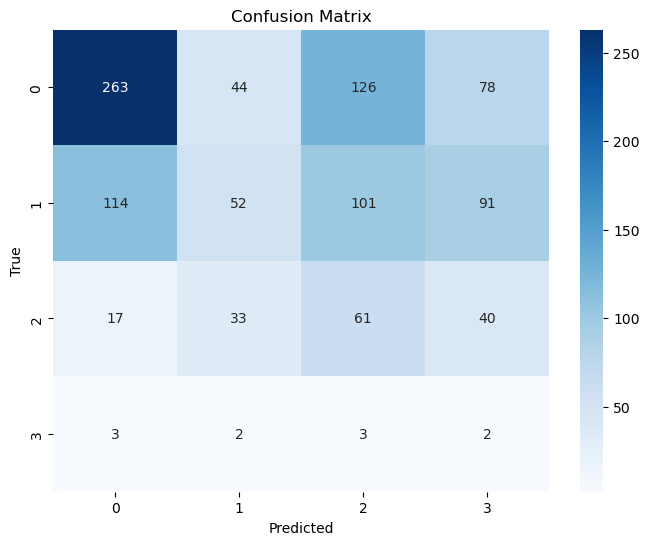

F2 Score: 0.3754284672657875
Matthews Correlation Coefficient: 0.13346554140569378
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.51      0.58       511
           1       0.40      0.15      0.21       358
           2       0.21      0.40      0.28       151
           3       0.01      0.20      0.02        10

    accuracy                           0.37      1030
   macro avg       0.32      0.32      0.27      1030
weighted avg       0.50      0.37      0.40      1030



TypeError: cannot unpack non-iterable NoneType object

In [72]:
print(best_params)

best_f2_score, best_mcc = logistic_regression(X_train, y_train, X_test, y_test, best_params['C'], best_params['penalty'],best_params['max_iter'], best_params['multi_class'],best_params['class_weight'])